# 3D-CNN Vessel-UNet segment

In [1]:
import os
import numpy as np
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge
from keras.optimizers import SGD, Adam
from keras.layers import Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers import Conv2D
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras import backend as K
from glob import glob
import tensorflow as tf

import matplotlib.pyplot as plt
from skimage.measure import label,regionprops, perimeter
from skimage import measure, feature
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



#################
#	Defining some functions for train
#################

# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 0.1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)


#################
#	UNet-define
#################
def unet1(inputs_shape, kernel_size=3, pool_size=2):
    """
    :param inputs_shape: tuple,e.g.(bs,512,512)
    :param kernel_size:
    :param pool_size:
    :return:
    """   
    inputs = Input(inputs_shape, name='inputs')  # (bs,512,512)
    conv1 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 1))(conv1)

    conv2 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 1))(conv2)
               
    conv3 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 1))(conv3)
                         

    conv4 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
    
    conv5 = Convolution3D(48, 3, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution3D(48, 3, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling3D(size=(2, 2, 2))(conv5), conv4], mode='concat', concat_axis=4)
    conv6 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling3D(size=(2, 2, 1))(conv6), conv3], mode='concat', concat_axis=4)
    conv7 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling3D(size=(2, 2, 1))(conv7), conv2], mode='concat', concat_axis=4)
    conv8 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling3D(size=(2, 2, 1))(conv8), conv1], mode='concat', concat_axis=4)
    conv9 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution3D(1, 1, 1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    model.summary()
    return model


def unet(inputs_shape, kernel_size=3, pool_size=2):
    """
    :param inputs_shape: tuple,e.g.(bs,512,512)
    :param kernel_size:
    :param pool_size:
    :return:
    """   
    inputs = Input(inputs_shape, name='inputs')  # (bs,512,512)
    conv1 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 1))(conv1)

    conv2 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 1))(conv2)
               
    conv3 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 1))(conv3)
                         

    conv4 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
    
    conv5 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)

    up6 = merge([UpSampling3D(size=(2, 2, 2))(conv5), conv4], mode='concat', concat_axis=4)
    conv6 = Dropout(0.3)(up6)
    conv6 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling3D(size=(2, 2, 1))(conv6), conv3], mode='concat', concat_axis=4)
    conv7 = Dropout(0.3)(up7)
    conv7 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling3D(size=(2, 2, 1))(conv7), conv2], mode='concat', concat_axis=4)
    conv8 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling3D(size=(2, 2, 1))(conv8), conv1], mode='concat', concat_axis=4)
    conv9 = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution3D(24, 3, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution3D(1, 1, 1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    model.summary()
    return model


model = unet((512, 512, 64, 1))

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (3, 3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(16, (3, 3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(24, (3, 3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:131: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/leg

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 512, 512, 64, 1)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 512, 512, 64, 32)  896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 512, 64, 32)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 512, 512, 64, 16)  13840     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 256, 256, 64, 16)  0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 256, 256, 64, 16)  6928      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256, 64, 16)  0         
__________

/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(1, (1, 1, 1), activation="sigmoid")`
  '` call to the Keras 2 API: ' + signature)


In [2]:
import matplotlib.pyplot as plt
from skimage.measure import label,regionprops, perimeter
from skimage import measure, feature
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-1000):   
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]    
    #print len(measure.marching_cubes(p, threshold))
    verts, faces, a, b = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

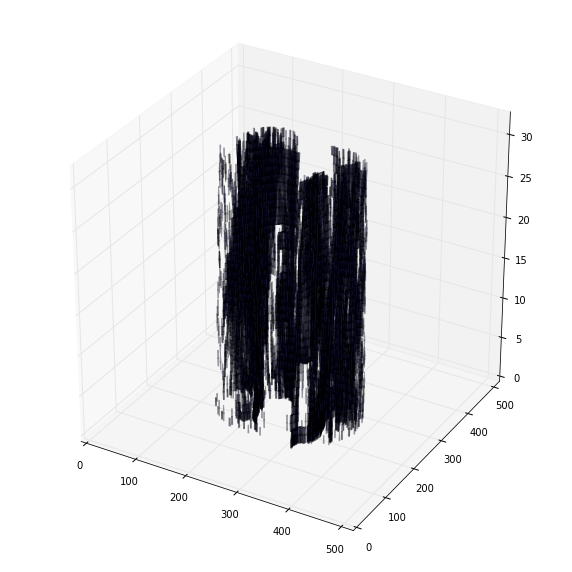

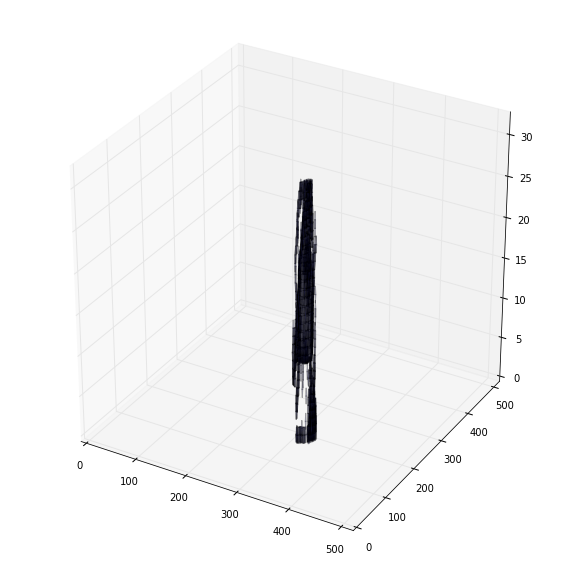

In [11]:
#a = np.load('/media/izm/Entertain/fjj/classify/classify/delted/dlt-LKDS-00852.mhd.npy')
b = np.load('/media/izm/Docs/FJJ-vessels/vessel-for-unet/unet-in-LKDS-00065.mhd-1.npy')
c = np.load('/media/izm/Docs/FJJ-vessels/vessel-for-unet/unet-lb-LKDS-00065.mhd-1.npy')
plot_3d(b, -1000)
plot_3d(c, -1000)


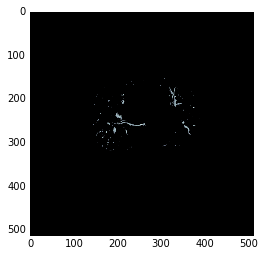

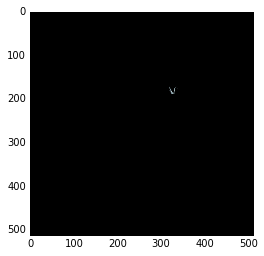

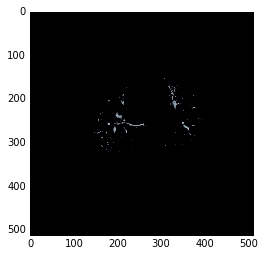

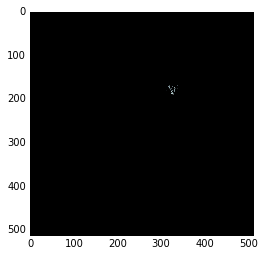

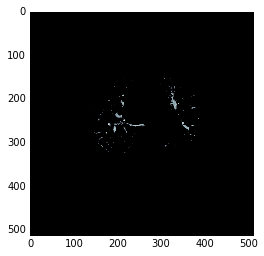

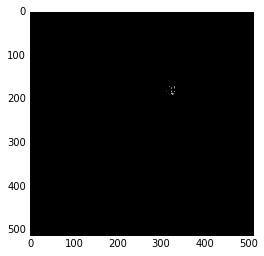

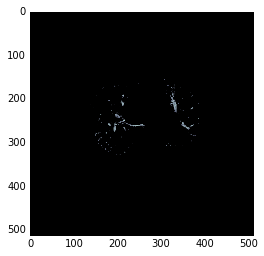

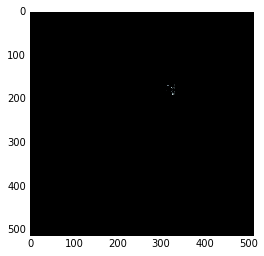

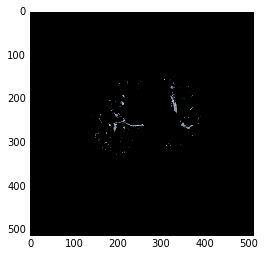

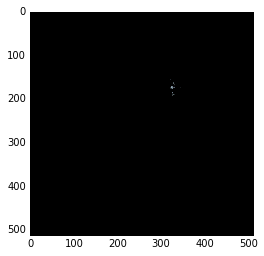

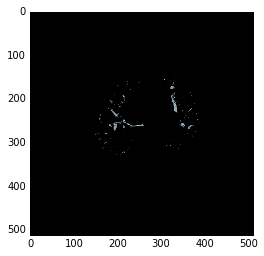

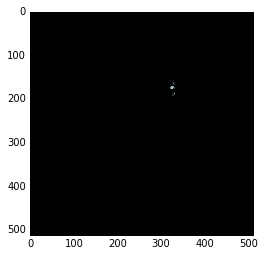

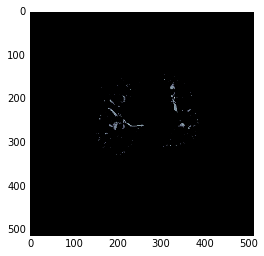

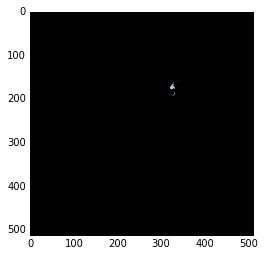

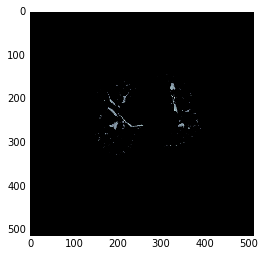

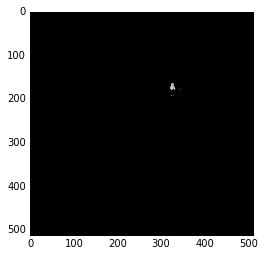

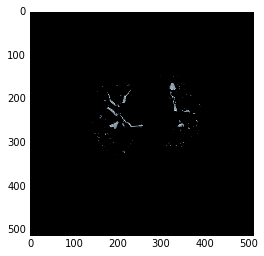

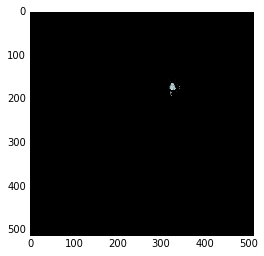

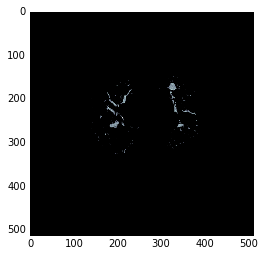

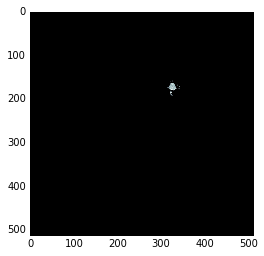

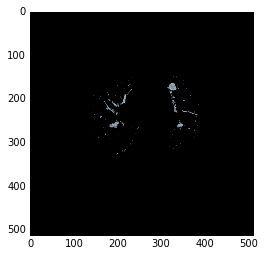

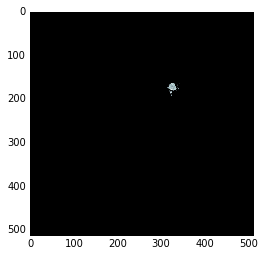

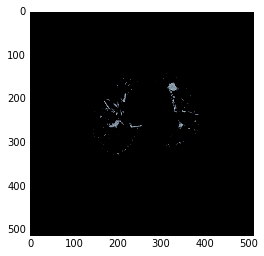

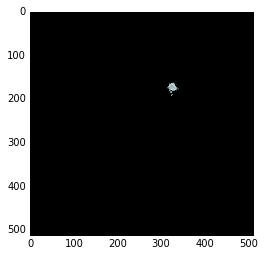

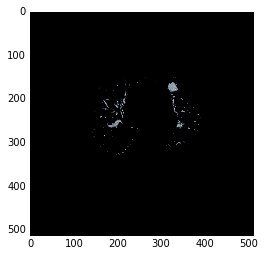

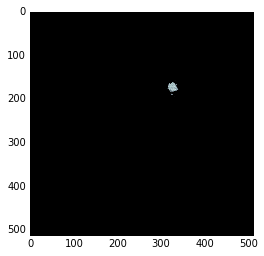

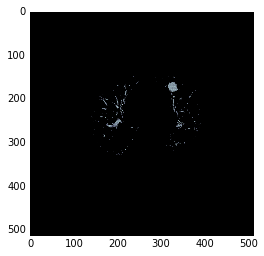

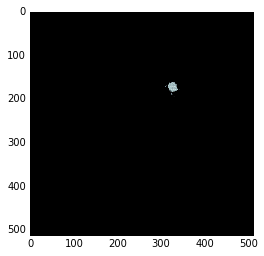

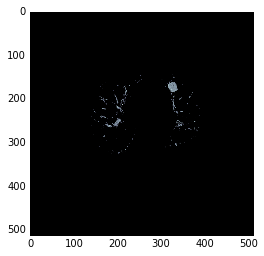

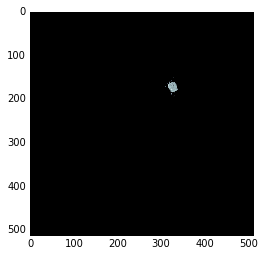

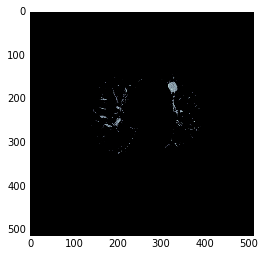

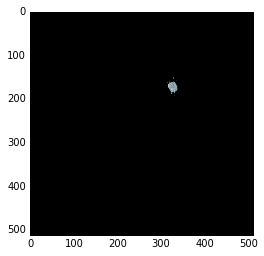

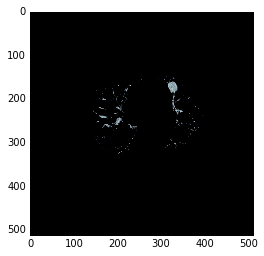

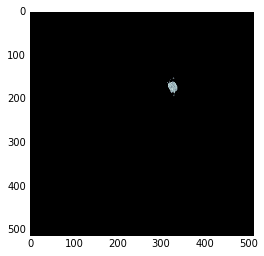

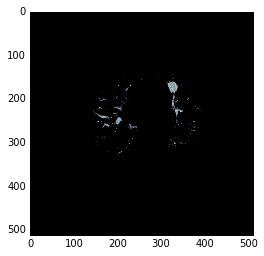

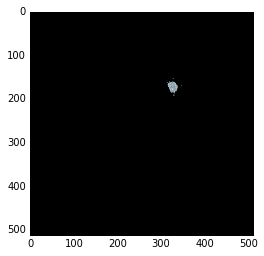

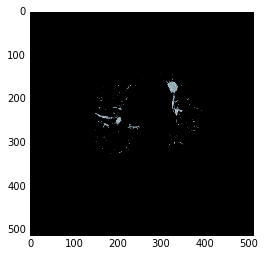

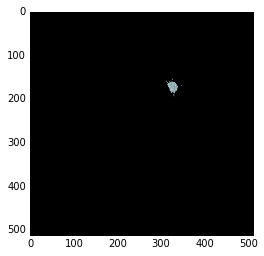

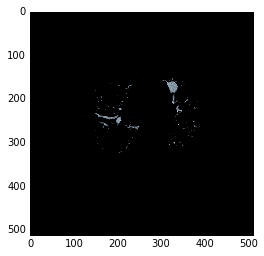

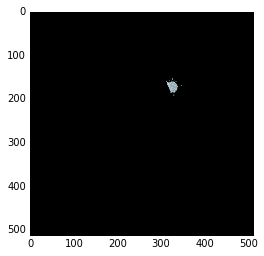

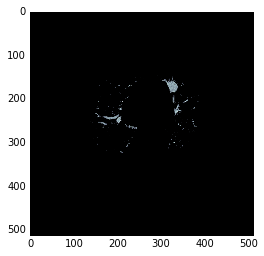

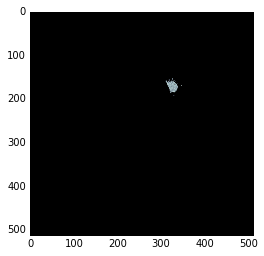

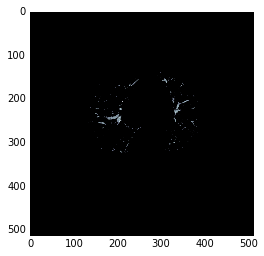

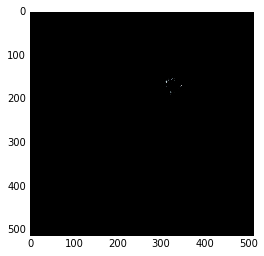

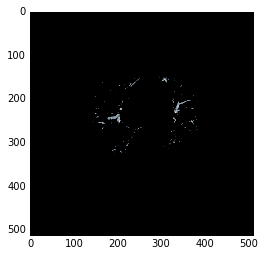

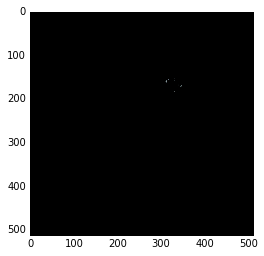

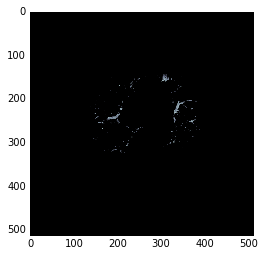

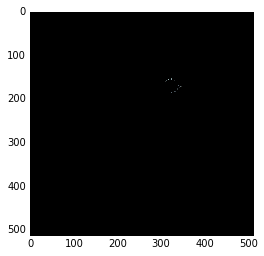

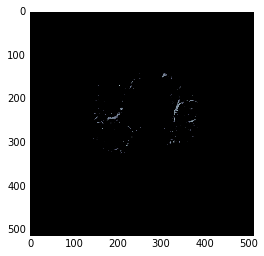

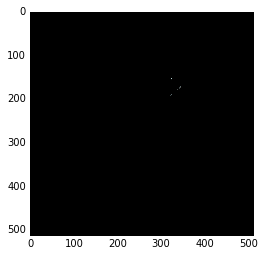

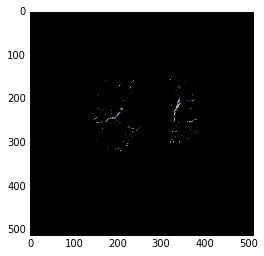

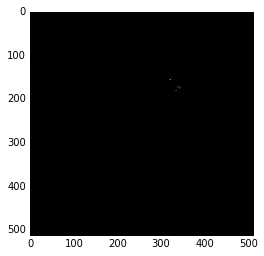

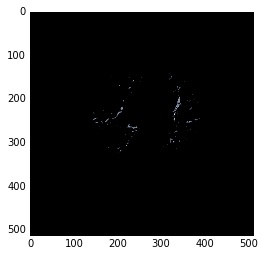

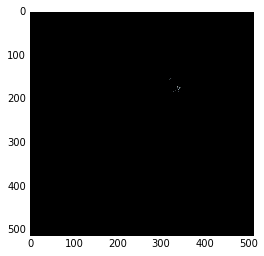

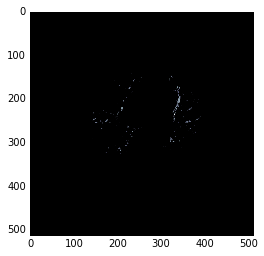

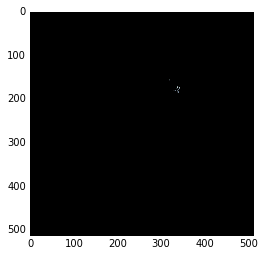

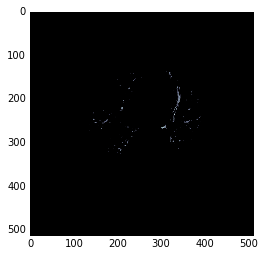

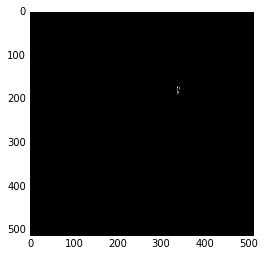

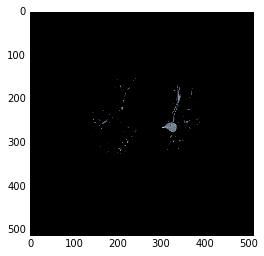

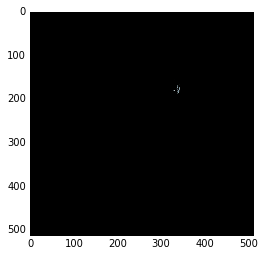

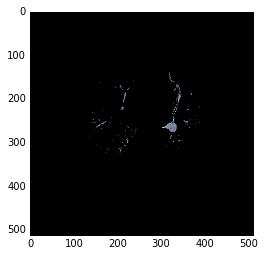

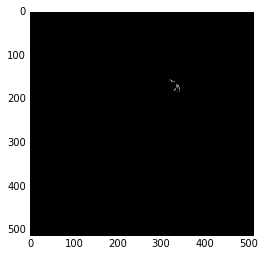

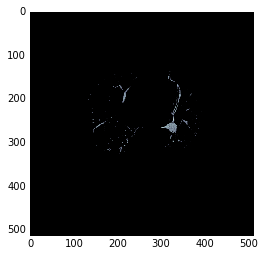

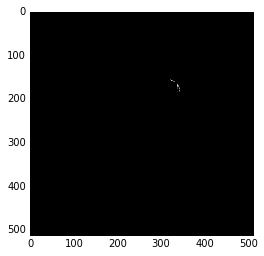

In [16]:

for i in range(b.shape[0]):
    slc = b[i]
    slc1 = c[i]
    plot = plt.subplot()
    plot.imshow(slc, cmap=plt.cm.bone)
    plt.show()
    plot = plt.subplot()
    plot.imshow(slc1, cmap=plt.cm.bone)
    plt.show()

In [3]:
def load_data(p, q):
    #lb_prefix = "vessel-unet/unet-lb-"
    #input_prefix = "vessel-unet/unet-in-"
    lb_prefix = "/media/izm/Docs/FJJ-vessels/vessel-for-unet/unet-lb-"
    input_prefix = "/media/izm/Docs/FJJ-vessels/vessel-for-unet/unet-in-"
    file_name = "label.txt"
    fp = open(file_name)
    lines = fp.readlines()
    valid_scan_name = []

    
    #only use the file marked '1'
    for line in lines:
        words = line.split()
        if words[1] == '0':
            valid_scan_name.append(words[0])
    
    print 'size=', len(valid_scan_name)
    #concat all the cts picture to form the big array
    data_mat = []
    lb_mat = []
    for pic in valid_scan_name[p:q]:
        print pic
        ip = np.load(input_prefix+pic+'.npy')        
        lb = np.load(lb_prefix+pic+'.npy')
        lb[lb != -1000] = 1
        lb[lb == -1000] = 0
        if ip.shape[0] < 64:
            blank = np.zeros([64-ip.shape[0], 512, 512])
            lb = np.concatenate((blank,lb))
           
            blank1 = np.zeros([64-ip.shape[0], 512, 512])
            blank1[:][:][:] = -1000
            ip = np.concatenate((blank1,ip))
                      
        data_mat.append([ip])
        lb_mat.append([lb])

    data_mat = np.array(data_mat).transpose([0,3,4,2,1])
    lb_mat = np.array(lb_mat).transpose([0,3,4,2,1])
    
    return data_mat, lb_mat

train_data, train_lb = load_data(0,3)

size= 379
LKDS-00001.mhd-1
LKDS-00003.mhd-2
LKDS-00004.mhd-1


In [15]:
print train_data.shape

(3, 512, 512, 64, 1)


In [4]:
initial_lr = 1e-5
optimizer = Adam(lr = initial_lr)
loss = dice_coef_loss
metrics = [dice_coef]
batch_size = 1
nb_epoch = 1

model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 
model.fit(train_data, train_lb, batch_size = 1, epochs = 1)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[1,512,512,64,32]
	 [[Node: conv3d_15/convolution = Conv3D[T=DT_FLOAT, padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_inputs_1_0/_19, conv3d_15/kernel/read)]]
	 [[Node: mul_3/_49 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_12922_mul_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'conv3d_15/convolution', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-d7ea71544d0c>", line 156, in <module>
    model = unet((512, 512, 64, 1))
  File "<ipython-input-2-d7ea71544d0c>", line 109, in unet
    conv1 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(inputs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/convolutional.py", line 172, in call
    dilation_rate=self.dilation_rate)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 2978, in conv3d
    data_format='NDHWC')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 639, in convolution
    op=op)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 308, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 631, in op
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 140, in _non_atrous_convolution
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 522, in conv3d
    strides=strides, padding=padding, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,512,512,64,32]
	 [[Node: conv3d_15/convolution = Conv3D[T=DT_FLOAT, padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_inputs_1_0/_19, conv3d_15/kernel/read)]]
	 [[Node: mul_3/_49 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_12922_mul_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
